In [1]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=5000, centers=2, 
                  cluster_std=[7, 3], n_features=2, 
                  random_state=43)

In [2]:
n_samples = len(X)
n_samples

5000

In [3]:
import numpy as np

r1 = np.random.randint(low=-100, high=100, 
                       size=(n_samples,)).astype(int)

r2 = np.random.randint(low=-100, high=100, 
                       size=(n_samples,)).astype(int)

In [4]:
import pandas as pd

all_df = pd.DataFrame(dict(label=y, a=X[:,0], 
                           b=X[:,1], c=r1, d=r2))
print(all_df)

      label          a          b   c   d
0         1  -8.837413  -6.551265  23 -75
1         1  -9.216749  -2.483494   2 -51
2         1  -2.017317  -6.326533  91  34
3         1 -10.748736  -4.622519   8 -78
4         0  -3.675848  12.629029  47  32
...     ...        ...        ...  ..  ..
4995      0   0.659784   1.414005  50 -36
4996      0 -12.388167  -3.860623   2 -49
4997      1  -4.294561  -8.472893 -41 -14
4998      1  -6.044883  -5.261760 -49 -97
4999      1  -3.585282  -4.820821  88  51

[5000 rows x 5 columns]


In [5]:
all_df['index'] = range(1, len(all_df) + 1)
all_df

,label,a,b,c,d,index
0,1,-8.837413,-6.551265,23,-75,1
1,1,-9.216749,-2.483494,2,-51,2
2,1,-2.017317,-6.326533,91,34,3
3,1,-10.748736,-4.622519,8,-78,4
4,0,-3.675848,12.629029,47,32,5
...,...,...,...,...,...,...
4995,0,0.659784,1.414005,50,-36,4996
4996,0,-12.388167,-3.860623,2,-49,4997
4997,1,-4.294561,-8.472893,-41,-14,4998
4998,1,-6.044883,-5.261760,-49,-97,4999


In [6]:
from time import time, sleep

def generate_event_time_records(num_records):
    time_value = int(round(time()))
    output = pd.Series([time_value]*num_records, 
                       dtype="float64")
    
    return output

In [7]:
generate_event_time_records(5000)

0       1.621862e+09
1       1.621862e+09
2       1.621862e+09
3       1.621862e+09
4       1.621862e+09
            ...     
4995    1.621862e+09
4996    1.621862e+09
4997    1.621862e+09
4998    1.621862e+09
4999    1.621862e+09
Length: 5000, dtype: float64

In [27]:
all_df["event_time"] = generate_event_time_records(
    len(all_df)
)

all_df

,label,a,b,c,d,index,event_time
0,1,-8.837413,-6.551265,23,-75,1,1.621875e+09
1,1,-9.216749,-2.483494,2,-51,2,1.621875e+09
2,1,-2.017317,-6.326533,91,34,3,1.621875e+09
3,1,-10.748736,-4.622519,8,-78,4,1.621875e+09
4,0,-3.675848,12.629029,47,32,5,1.621875e+09
...,...,...,...,...,...,...,...
4995,0,0.659784,1.414005,50,-36,4996,1.621875e+09
4996,0,-12.388167,-3.860623,2,-49,4997,1.621875e+09
4997,1,-4.294561,-8.472893,-41,-14,4998,1.621875e+09
4998,1,-6.044883,-5.261760,-49,-97,4999,1.621875e+09


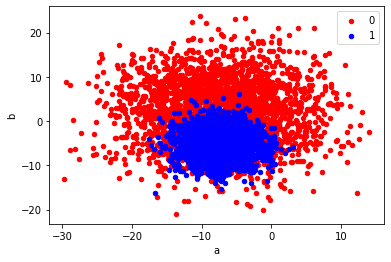

In [10]:
from matplotlib import pyplot

colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = all_df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, 
               kind='scatter', 
               x='a', 
               y='b', 
               label=key, 
               color=colors[key])
    
pyplot.show()

In [11]:
import boto3
import sagemaker
from sagemaker.session import Session

In [12]:
region = boto3.Session().region_name
session = boto3.Session(region_name=region)

client = session.client(
    service_name='sagemaker', 
    region_name=region
)

runtime = session.client(
    service_name='sagemaker-featurestore-runtime', 
    region_name=region
)

feature_store_session = Session(
    boto_session=session,
    sagemaker_client=client,
    sagemaker_featurestore_runtime_client=runtime
)

In [13]:
s3_bucket_name = "sagemaker-cookbook-bucket"
prefix = "chapter07"

from sagemaker import get_execution_role
role = get_execution_role()

In [14]:
s3_client = boto3.client('s3', region_name=region)

In [15]:
feature_group_name = 'cookbook-feature-group'

In [16]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    name=feature_group_name, 
    sagemaker_session=feature_store_session
)

In [17]:
try:
    feature_group.delete()
    sleep(30)
except:
    print("Feature group does not exist")
    pass

In [18]:
%%time

feature_group.load_feature_definitions(data_frame=all_df)
sleep(1)

CPU times: user 2.35 ms, sys: 409 µs, total: 2.75 ms
Wall time: 1 s


In [19]:
feature_group.create(
    s3_uri=f"s3://{s3_bucket_name}/{prefix}/input",
    record_identifier_name="index",
    event_time_feature_name="event_time",
    role_arn=role,
    enable_online_store=True
)

sleep(60)

In [20]:
feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:581320662326:feature-group/cookbook-feature-group',
 'FeatureGroupName': 'cookbook-feature-group',
 'RecordIdentifierFeatureName': 'index',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'label', 'FeatureType': 'Integral'},
  {'FeatureName': 'a', 'FeatureType': 'Fractional'},
  {'FeatureName': 'b', 'FeatureType': 'Fractional'},
  {'FeatureName': 'c', 'FeatureType': 'Integral'},
  {'FeatureName': 'd', 'FeatureType': 'Integral'},
  {'FeatureName': 'index', 'FeatureType': 'Integral'},
  {'FeatureName': 'event_time', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2021, 5, 24, 13, 18, 9, 536000, tzinfo=tzlocal()),
 'OnlineStoreConfig': {'EnableOnlineStore': True},
 'OfflineStoreConfig': {'S3StorageConfig': {'S3Uri': 's3://sagemaker-cookbook-bucket/chapter07/input',
   'ResolvedOutputS3Uri': 's3://sagemaker-cookbook-bucket/chapter07/input/581320662326/sagemaker/us-east-1/offline-store/cookbook

In [21]:
feature_group.describe().get("FeatureGroupStatus")

'Created'

In [22]:
client.list_feature_groups()

{'FeatureGroupSummaries': [{'FeatureGroupName': 'feature-group-16-17-50-17',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:581320662326:feature-group/feature-group-16-17-50-17',
   'CreationTime': datetime.datetime(2021, 1, 16, 17, 50, 42, 246000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'feature-group-10-20-17-14',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:581320662326:feature-group/feature-group-10-20-17-14',
   'CreationTime': datetime.datetime(2021, 1, 10, 20, 26, 30, 564000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'cookbook-feature-group-07',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:581320662326:feature-group/cookbook-feature-group-07',
   'CreationTime': datetime.datetime(2021, 1, 17, 0, 29, 3, 52000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status

In [23]:
all_df.dtypes

label           int64
a             float64
b             float64
c               int64
d               int64
index           int64
event_time    float64
dtype: object

In [24]:
%%time

feature_group.ingest(
    data_frame=all_df, max_workers=3, wait=True
)

CPU times: user 15.2 ms, sys: 22.8 ms, total: 38 ms
Wall time: 21 s


IngestionManagerPandas(feature_group_name='cookbook-feature-group', sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7f8a487356d0>, max_workers=3, max_processes=1, _async_result=<multiprocess.pool.MapResult object at 0x7f8a4e689410>, _processing_pool=<pool ProcessPool(ncpus=1)>, _failed_indices=[])

In [25]:
runtime.get_record(
    FeatureGroupName=feature_group.name, 
    RecordIdentifierValueAsString="5000"
)

{'ResponseMetadata': {'RequestId': '7ce3226e-7168-4ccd-95a7-ed65f22d840f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7ce3226e-7168-4ccd-95a7-ed65f22d840f',
   'content-type': 'application/json',
   'content-length': '359',
   'date': 'Mon, 24 May 2021 13:19:31 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'label', 'ValueAsString': '1'},
  {'FeatureName': 'a', 'ValueAsString': '-3.585282409963491'},
  {'FeatureName': 'b', 'ValueAsString': '-4.820820583530444'},
  {'FeatureName': 'c', 'ValueAsString': '88'},
  {'FeatureName': 'd', 'ValueAsString': '51'},
  {'FeatureName': 'index', 'ValueAsString': '5000'},
  {'FeatureName': 'event_time', 'ValueAsString': '1621862257.0'}]}

In [26]:
%store feature_group_name
%store s3_bucket_name
%store prefix

Stored 'feature_group_name' (str)
Stored 's3_bucket_name' (str)
Stored 'prefix' (str)
